- Make the image size and batch size larger

In [1]:
# """
# images
#     ai
#     real
# test

# splits into train and test folders

# data
#     train
#         ai
#         real
#     test
#         ai
#         real
#     val
#         ai
#         real
# test
# """
# import splitfolders

# splitfolders.ratio("images", # The location of dataset
#                    output="data", # The output location
#                    seed=42, # The number of seed
#                    ratio=(.7, .3, 0), # The ratio of splited dataset
#                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                    move=False # If you choose to move, turn this into True
#                    )

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory('data/train', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory('data/val', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1004 files belonging to 2 classes.
Found 376 files belonging to 2 classes.


In [5]:
next(iter(train_dataset))

(<tf.Tensor: shape=(64, 160, 160, 3), dtype=float32, numpy=
 array([[[[214.93655  , 214.93655  , 214.93655  ],
          [219.22797  , 219.22797  , 219.22797  ],
          [225.56953  , 225.56953  , 225.56953  ],
          ...,
          [221.17969  , 221.17969  , 221.17969  ],
          [226.92783  , 226.92783  , 226.92783  ],
          [223.33205  , 223.33205  , 223.33205  ]],
 
         [[230.47984  , 230.47984  , 230.47984  ],
          [224.83469  , 224.83469  , 224.83469  ],
          [227.1711   , 227.1711   , 227.1711   ],
          ...,
          [223.60703  , 223.60703  , 223.60703  ],
          [225.30278  , 225.30278  , 225.30278  ],
          [212.89519  , 212.89519  , 212.89519  ]],
 
         [[224.00859  , 224.00859  , 224.00859  ],
          [227.10938  , 227.10938  , 227.10938  ],
          [233.85938  , 233.85938  , 233.85938  ],
          ...,
          [229.07422  , 229.07422  , 229.07422  ],
          [230.44838  , 230.44838  , 230.44838  ],
          [211.40083  

In [6]:
class_names = train_dataset.class_names
print(class_names)

['ai', 'real']


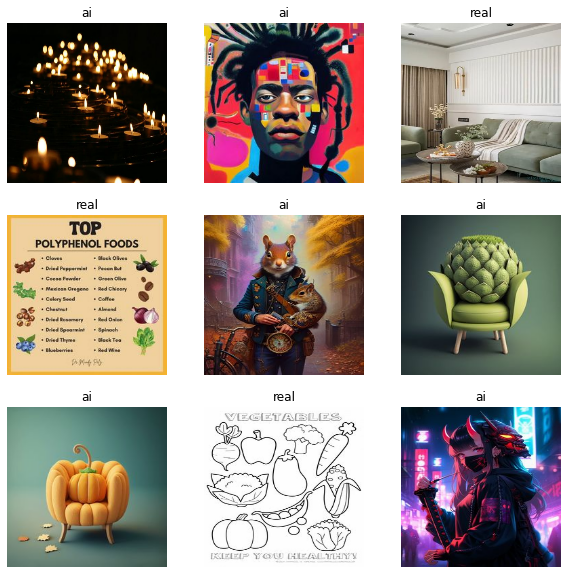

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Split the validation set to create a test set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 5
Number of test batches: 1


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

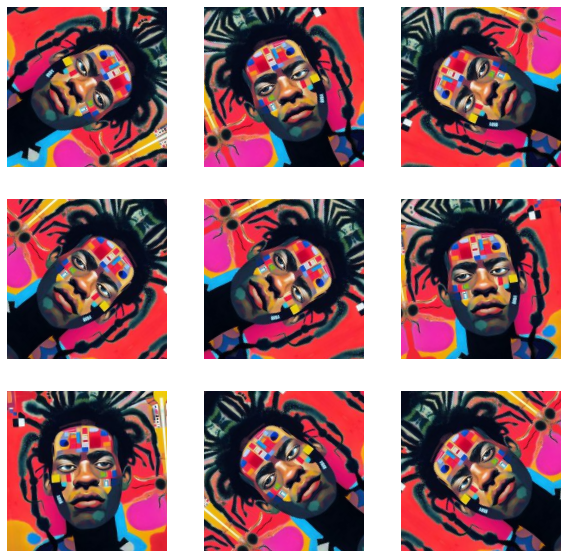

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
# converts each image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [15]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 block_1_project_BN (BatchNorma  (None, 40, 40, 24)  96          ['block_1_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_2_expand (Conv2D)        (None, 40, 40, 144)  3456        ['block_1_project_BN[0][0]']     
                                                                                                  
 block_2_expand_BN (BatchNormal  (None, 40, 40, 144)  576        ['block_2_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_2_expand_relu (ReLU)     (None, 40, 40, 144)  0           ['block_2_expand_BN[0][0]']      
                                                                                                  
 block_2_d

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Compiling the Model

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [21]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 4s 274ms/step - loss: 0.7608 - accuracy: 0.5288


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.53


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


16/16 [==============================] - 18s 668ms/step - loss: 0.8220 - accuracy: 0.5010 - val_loss: 0.7296 - val_accuracy: 0.5673
Epoch 2/20
16/16 [==============================] - 12s 691ms/step - loss: 0.8133 - accuracy: 0.5090 - val_loss: 0.7287 - val_accuracy: 0.5673
Epoch 3/20
16/16 [==============================] - 10s 611ms/step - loss: 0.8157 - accuracy: 0.5209 - val_loss: 0.7279 - val_accuracy: 0.5801
Epoch 4/20
16/16 [==============================] - 10s 595ms/step - loss: 0.7922 - accuracy: 0.5319 - val_loss: 0.7059 - val_accuracy: 0.6122
Epoch 5/20
16/16 [==============================] - 10s 617ms/step - loss: 0.7769 - accuracy: 0.5627 - val_loss: 0.7044 - val_accuracy: 0.6122
Epoch 6/20
16/16 [==============================] - 11s 633ms/step - loss: 0.7413 - accuracy: 0.5807 - val_loss: 0.6924 - val_accuracy: 0.6186
Epoch 7/20
16/16 [==============================] - 11s 635ms/step - loss: 0.7504 - accuracy: 0.5647 - val_loss: 0.6738 - val_accuracy: 0.6378
Epoch 8/20

## Learning Curves

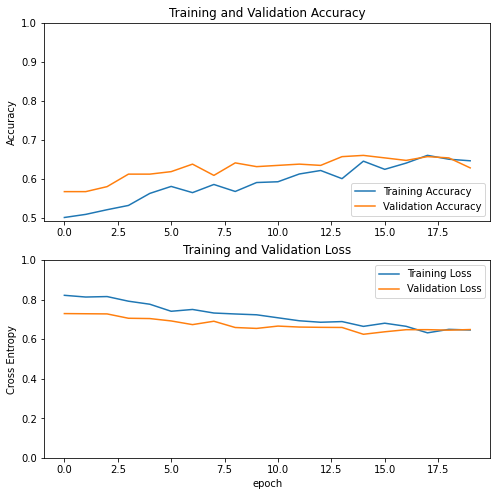

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [29]:
# Continue training the model

fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


16/16 [==============================] - 27s 824ms/step - loss: 0.6184 - accuracy: 0.6813 - val_loss: 0.5766 - val_accuracy: 0.6987
Epoch 21/40
16/16 [==============================] - 12s 678ms/step - loss: 0.5440 - accuracy: 0.7271 - val_loss: 0.5672 - val_accuracy: 0.7083
Epoch 22/40
16/16 [==============================] - 11s 646ms/step - loss: 0.5280 - accuracy: 0.7410 - val_loss: 0.5809 - val_accuracy: 0.6891
Epoch 23/40
16/16 [==============================] - 10s 625ms/step - loss: 0.4983 - accuracy: 0.7550 - val_loss: 0.5401 - val_accuracy: 0.7340
Epoch 24/40
16/16 [==============================] - 18s 651ms/step - loss: 0.4751 - accuracy: 0.7639 - val_loss: 0.5208 - val_accuracy: 0.7468
Epoch 25/40
16/16 [==============================] - 10s 623ms/step - loss: 0.4629 - accuracy: 0.7898 - val_loss: 0.5147 - val_accuracy: 0.7596
Epoch 26/40
16/16 [==============================] - 10s 620ms/step - loss: 0.4507 - accuracy: 0.7869 - val_loss: 0.5176 - val_accuracy: 0.7628
Epoc

In [30]:
# Looking at the learning curves of the model
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

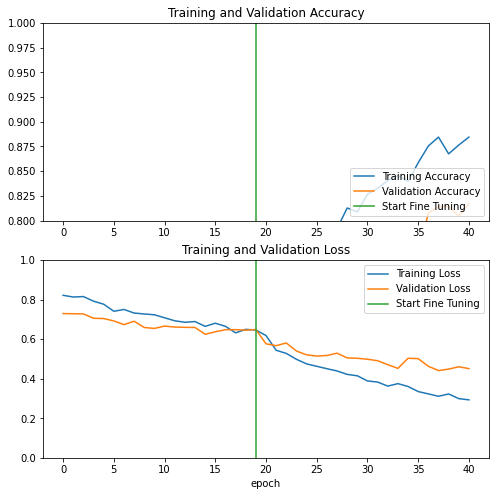

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluating the Model

In [32]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 589ms/step - loss: 0.3686 - accuracy: 0.8594
Test accuracy : 0.859375


Predictions:
 [0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1]
Labels:
 [1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1
 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1]


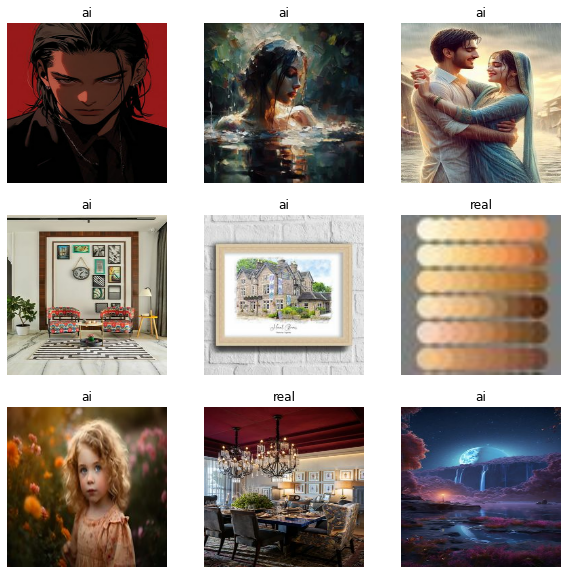

In [33]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = np.round(predictions)
predictions = np.int8(predictions)
predictions = tf.convert_to_tensor(predictions)


print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [34]:
# Saving the model
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
model.save("model2.h5")